In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


#  Import and read the charity_data.csv.
application_df = pd.read_csv("Resources/charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [2]:
# Convert ASK_AMOUNT to bins because the data is severely skewed right
ask_bins=[0, 5000, 100000, 1000000, 9000000000]
bin_labels=["5,000","5001-100,000", "100,001-1 million", "over 1 million"]
application_df["ask_amount"]=pd.cut(application_df["ASK_AMT"], ask_bins, labels=bin_labels).astype(str)
application_df.drop(columns=["ASK_AMT"], inplace=True)
print(application_df.dtypes)
print(application_df.ask_amount.value_counts())

EIN                        int64
NAME                      object
APPLICATION_TYPE          object
AFFILIATION               object
CLASSIFICATION            object
USE_CASE                  object
ORGANIZATION              object
STATUS                     int64
INCOME_AMT                object
SPECIAL_CONSIDERATIONS    object
IS_SUCCESSFUL              int64
ask_amount                object
dtype: object
5,000                25398
5001-100,000          4370
100,001-1 million     2954
over 1 million        1577
Name: ask_amount, dtype: int64


In [3]:
# Prepare data
# Drop the non-beneficial ID columns, 'EIN' and 'NAME' and transformed varible ASK_AMT
application_df.drop(["EIN", "NAME", "STATUS", "SPECIAL_CONSIDERATIONS"], axis=1, inplace=True)

# Determine which values to replace if counts are less than ...?
app_type_cnts=application_df["APPLICATION_TYPE"].value_counts(dropna=False)
replace_application=list(app_type_cnts[app_type_cnts<500].index)
# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")

# Determine which values to replace if counts are less than ..?
class_type_cnts=application_df["CLASSIFICATION"].value_counts(dropna=False)
replace_class=list(class_type_cnts[class_type_cnts<1883].index)
# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")
       
# Generate our categorical variable lists
application_cat =application_df.dtypes[application_df.dtypes =="object"].index.tolist()

# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)
# Fit and transform the OneHotEncoder using the categorical variable list
encode_df =pd.DataFrame(enc.fit_transform(application_df[application_cat]))
# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(application_cat)

# Merge one-hot encoded features and drop the originals
application_df =application_df.merge(encode_df,left_index=True,right_index=True)
application_df =application_df.drop(application_cat,1)
print(application_df.columns)

# Split our preprocessed data into our features and target arrays
y =application_df["IS_SUCCESSFUL"].values
X =application_df.drop(["IS_SUCCESSFUL"],1).values

# Split the preprocessed data into a training and testing dataset
X_train,X_test,y_train,y_test =train_test_split(X,y,stratify=y,random_state=78)

# Create a StandardScaler instances
scaler = StandardScaler()
# Fit the StandardScaler
X_scaler = scaler.fit(X_train)
# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)



Index(['IS_SUCCESSFUL', 'APPLICATION_TYPE_Other', 'APPLICATION_TYPE_T10',
       'APPLICATION_TYPE_T19', 'APPLICATION_TYPE_T3', 'APPLICATION_TYPE_T4',
       'APPLICATION_TYPE_T5', 'APPLICATION_TYPE_T6', 'APPLICATION_TYPE_T7',
       'APPLICATION_TYPE_T8', 'AFFILIATION_CompanySponsored',
       'AFFILIATION_Family/Parent', 'AFFILIATION_Independent',
       'AFFILIATION_National', 'AFFILIATION_Other', 'AFFILIATION_Regional',
       'CLASSIFICATION_C1000', 'CLASSIFICATION_C1200', 'CLASSIFICATION_C2000',
       'CLASSIFICATION_C2100', 'CLASSIFICATION_C3000', 'CLASSIFICATION_Other',
       'USE_CASE_CommunityServ', 'USE_CASE_Heathcare', 'USE_CASE_Other',
       'USE_CASE_Preservation', 'USE_CASE_ProductDev',
       'ORGANIZATION_Association', 'ORGANIZATION_Co-operative',
       'ORGANIZATION_Corporation', 'ORGANIZATION_Trust', 'INCOME_AMT_0',
       'INCOME_AMT_1-9999', 'INCOME_AMT_10000-24999',
       'INCOME_AMT_100000-499999', 'INCOME_AMT_10M-50M', 'INCOME_AMT_1M-5M',
       'INCOME_AMT

In [4]:
# Define the model - deep neural net
# use validation_split argument to set the proportion of the dataset to reserve for validation

number_input_features =len(X_train[0])  
hidden_nodes_layer1 = 2
hidden_nodes_layer2 = 2
# hidden_nodes_layer3 = 2
nn = tf.keras.models.Sequential()
# hidden layers
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1,input_dim=number_input_features,activation="tanh"))
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2,activation="tanh"))
# nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3,activation="tanh"))
nn.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))

# Check the structure of the model
nn.summary()

# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path ="checkpoints/weights.{epoch:02d}.hdf5"

# Compile the model
nn.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

# Create a callback that saves the model's weights every epoch
cp_callback =ModelCheckpoint(filepath=checkpoint_path,verbose=1,save_weights_only=True, save_freq="epoch")

# Train the model
# fit_model =nn.fit(X_train_scaled,y_train, epochs=10)
fit_model =nn.fit(X_train_scaled,y_train,validation_split=0.3, epochs=30, callbacks=[cp_callback])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 88        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
484/563 [========================>.....] - ETA: 0s - loss: 0.6575 - accuracy: 0.6258
Epoch 00001: saving model to checkpoints\weights.01.hdf5
563/563 [==============================] - 0s 810us/step - loss: 0.6506 - accuracy: 0.6368 - val_loss: 0.6013 - val_accuracy: 0.7127
Epoch 2/30
525/563 [==========================>...] - ETA: 0s - loss: 0.5886 - accuracy: 0.7217
Epoch 00

Epoch 27/30
559/563 [============================>.] - ETA: 0s - loss: 0.5627 - accuracy: 0.7296
Epoch 00027: saving model to checkpoints\weights.27.hdf5
563/563 [==============================] - 0s 615us/step - loss: 0.5624 - accuracy: 0.7299 - val_loss: 0.5649 - val_accuracy: 0.7288
Epoch 28/30
476/563 [========================>.....] - ETA: 0s - loss: 0.5605 - accuracy: 0.7309
Epoch 00028: saving model to checkpoints\weights.28.hdf5
563/563 [==============================] - 0s 694us/step - loss: 0.5623 - accuracy: 0.7297 - val_loss: 0.5650 - val_accuracy: 0.7284
Epoch 29/30
553/563 [============================>.] - ETA: 0s - loss: 0.5621 - accuracy: 0.7295
Epoch 00029: saving model to checkpoints\weights.29.hdf5
563/563 [==============================] - 0s 632us/step - loss: 0.5619 - accuracy: 0.7296 - val_loss: 0.5645 - val_accuracy: 0.7293
Epoch 30/30
527/563 [===========================>..] - ETA: 0s - loss: 0.5618 - accuracy: 0.7310
Epoch 00030: saving model to checkpoints\w

In [5]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5612 - accuracy: 0.7297
Loss: 0.5612046718597412, Accuracy: 0.72967928647995


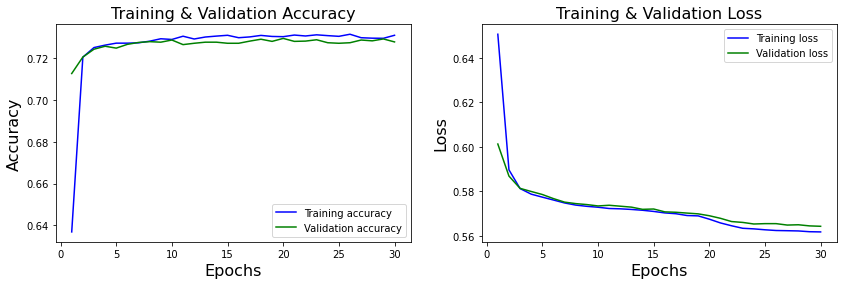

In [6]:
# Create learning curve for both train and validation datasets to evaluate under- and over-fitting

history_dict=fit_model.history
 
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'b', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'g', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'b', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'g', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

plt.show()